In what follows, we implement knowledge distillation on the CIFAR-10 dataset. The data is from the Canadian Institute for Advanced Research and it consists of 60,000 labelled images belonging to 10 categories.

We are able to distill a teacher of about 550k parameters into a student of about 50k parameters.

The Teacher accuracy on the test set is around 86% while the student is around 71%. However, when distillation is applied, the student performs with around 79% accuracy on the same test set.

## Importing Libraries

First, we prepare a few libraries and packages that will be used.

In [ ]:
!pip install keras.utils

  Preparing metadata (setup.py) ... done
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2631 sha256=c0aa8394f1b0310c856ea46ee106249a084713b6cf3c6ed2bb3fbde487701f03
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras.utils


In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
import os
import keras
from keras import layers
from keras import ops
import numpy as np
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras

from keras.datasets import cifar10
from keras.models import Sequential
from keras import datasets, layers, models
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.preprocessing import OneHotEncoder



## Visualizing and Preparing the Data
---


Next, we obtain the train and test sets from CIFAR-10.  

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


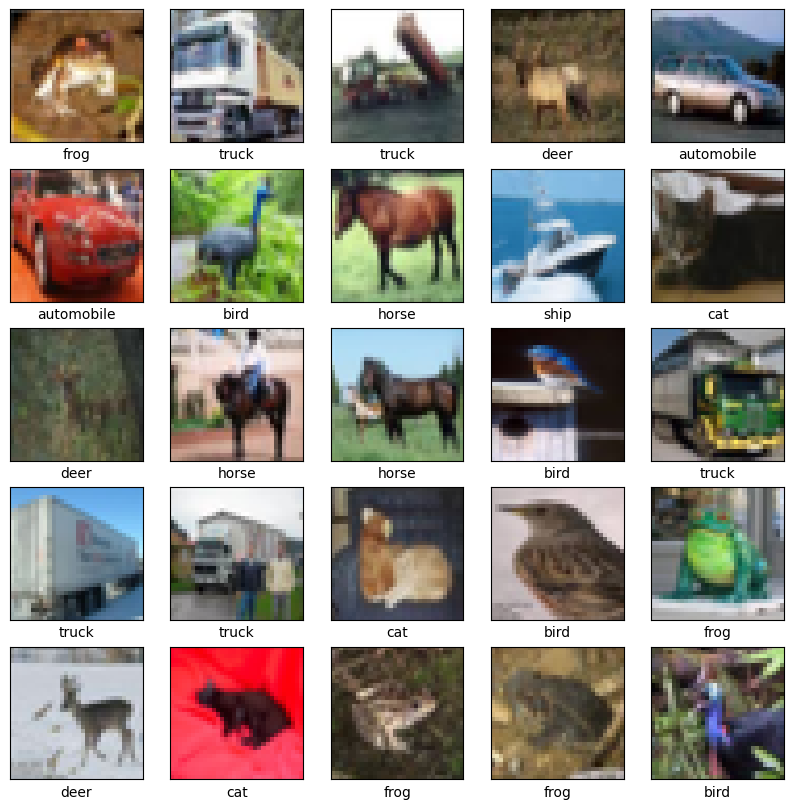

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


plt.figure(figsize=[10,10])
for i in range (25):    # for first 25 images
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[i][0]])

plt.show()


In [ ]:
#a standard batch size
batch_size = 64


# we use float 32 for better memory allocation
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

#we standardize
train_images = train_images / 255
test_images = test_images / 255

num_classes = 10

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)


train_images = np.reshape(train_images, (-1, 32, 32, 3))
test_images = np.reshape(test_images, (-1, 32, 32, 3))

print(f'train_images shape: {train_images.shape}')
print(f'train_labels shape: {train_labels.shape}')
print(f'test_images shape: {test_images.shape}')
print(f'test_labels shape: {test_labels.shape}')


train_images shape: (50000, 32, 32, 3)
train_labels shape: (50000, 1)
test_images shape: (10000, 32, 32, 3)
test_labels shape: (10000, 1)


## The Teacher Model

We base our teacher model on one from Kaggle: https://www.kaggle.com/code/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy

The difference is that our model has logits at the output instead of a softmax.
This is the standard for knowledge distillation as we will be applying a softmax with temperature in distillation.




In [ ]:
teacher = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Dropout(0.5),

        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),

        layers.Dropout(0.5),

        layers.Dense(num_classes),
    ],
    name="teacher",
)

teacher.summary()


Model: "teacher"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

## Train the teacher

As we discussed, in knowledge distillation, we start by training the big teacher model on the training set in the usual way.



In [ ]:
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

checkpoint_path = "training_teacher/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


teachers = teacher.fit(train_images, train_labels, batch_size=64, epochs=50)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 487s 614ms/step - loss: 2.0993 - sparse_categorical_accuracy: 0.3238
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 429s 549ms/step - loss: 1.2058 - sparse_categorical_accuracy: 0.5683
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 442s 549ms/step - loss: 1.0023 - sparse_categorical_accuracy: 0.6482
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 431s 535ms/step - loss: 0.8828 - sparse_categorical_accuracy: 0.6934
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 442s 535ms/step - loss: 0.8149 - sparse_categorical_accuracy: 0.7167
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 419s 536ms/step - loss: 0.7729 - sparse_categorical_accuracy: 0.7319
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 442s 536ms/step - loss: 0.7029 - sparse_categorical_accuracy: 0.7538
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 442s 536ms/step - loss: 0.6732 - sparse_categorical_accuracy: 0.7672
Epoch 9/50
 82/782 ━━━━━━━━━━━━━━━━━━━━ 6:23 548ms/step - loss: 0.6509 - sparse_categorical_accuracy: 0.7765

In [ ]:
teacher.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4044 - sparse_categorical_accuracy: 0.8701


[0.4072171747684479, 0.868399977684021]

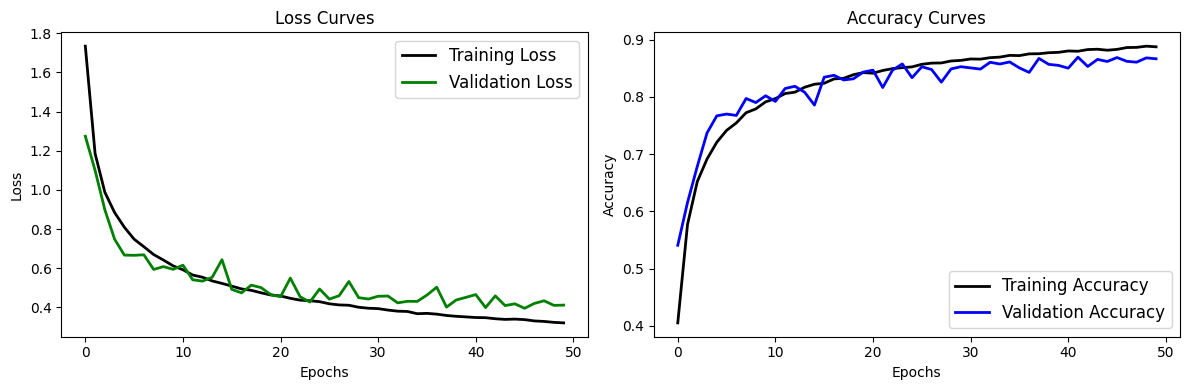

In [ ]:
fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(teachers.history['loss'], 'black', linewidth=2.0)
plt.plot(teachers.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
teacher.save_weights("/content/teacher.weights.h5")

## Creating the Student Model

Below, we create our own student model that is about 1/10th the teacher in terms of number of parameters. It has an identical number of layers, just like the one in the keras.io demo.

In [ ]:
num_classes = 10

student = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),
        layers.Conv2D(8, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(8, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),


        layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),

        layers.Dense(num_classes),
    ],
    name="student",
)


student_scratch = keras.models.clone_model(student)
student_copy = keras.models.clone_model(student)
student_copy_copy = keras.models.clone_model(student)

student.summary()

Model: "student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 16, 16, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 52,370 (204.57 KB)

 Trainable params: 52,018 (203.20 KB)

 Non-trainable params: 352 (1.38 KB)

## The Distiller

Our distiller is an adapted version of one found on keras.io:
https://keras.io/examples/vision/knowledge_distillation/


In [ ]:
class Distiller_new(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.2,
        temperature=3,
    ):
        """Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights

            metrics: Keras metrics for evaluation

            student_loss_fn: Loss function of difference between student
                predictions and ground-truth

            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions

            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn

            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            ops.softmax(teacher_pred / self.temperature, axis=1),
            ops.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self.student(x, training=True)

            loss = self.compute_loss(x, y, y_pred)

        gradients = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))

        self.compiled_metrics.update_state(y, y_pred)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data
        y_pred = self.student(x, training=False)

        loss = self.compute_loss(x, y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)

        return {m.name: m.result() for m in self.metrics}

## Distilling the Teacher

In [ ]:
d = Distiller_new(student= student, teacher=teacher)

d.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.2,
    temperature=5,
)

checkpoint_path = "training_student_distilled1/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


dis = d.fit(train_images, train_labels , epochs=50, batch_size= 64)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:578: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - sparse_categorical_accuracy: 0.4145 - loss: 8.3417e-04
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - sparse_categorical_accuracy: 0.6260 - loss: 0.0221
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - sparse_categorical_accuracy: 0.6853 - loss: 0.0183
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - sparse_categorical_accuracy: 0.7175 - loss: 0.0154
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - sparse_categorical_accuracy: 0.7416 - loss: 0.0112
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - sparse_categorical_accuracy: 0.7564 - loss: 0.0080
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - sparse_categorical_accuracy: 0.7743 - loss: 0.0042
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - sparse_categorical_accuracy: 0.7816 - loss: 0.0031
Epoch 9/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - sparse_categorical_accuracy: 0.7877 - loss: 0.0025
Epoch 10/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - spars

In [ ]:
d.save_weights("/content/distilled_student_1.weights.h5")

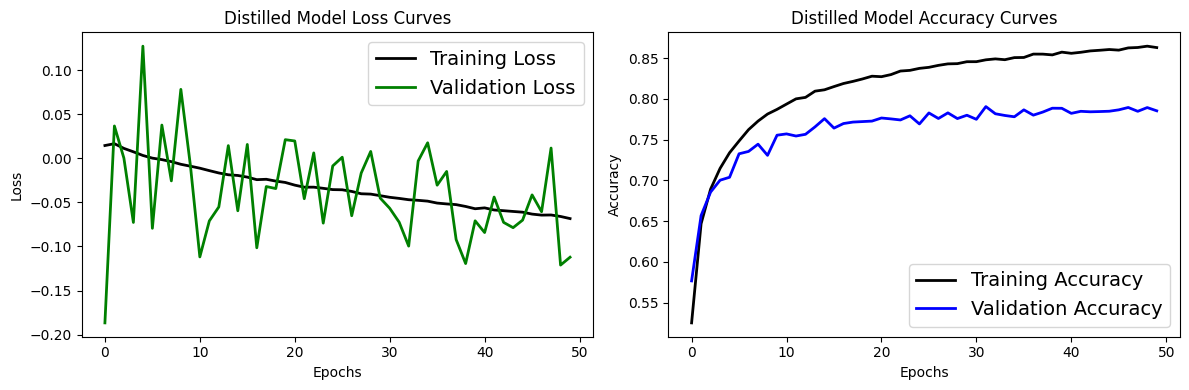

In [ ]:
fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(dis.history['loss'], 'black', linewidth=2.0)
plt.plot(dis.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Distilled Model Loss Curves', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(dis.history['sparse_categorical_accuracy'], 'black', linewidth=2.0)
plt.plot(dis.history['val_sparse_categorical_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Distilled Model Accuracy Curves', fontsize=12)

plt.tight_layout()
plt.show()

## Train student from scratch for comparison

We also train an equivalent student model from scratch without the teacher, in order to evaluate the performance gain obtained by knowledge distillation.

In [ ]:
# Train student as done usually
student_scratch.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

checkpoint_path = "training_student_scratch1/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

scratch = student_scratch.fit(train_images, train_labels, batch_size=64, epochs=50)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 1.7372 - sparse_categorical_accuracy: 0.3914
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.1566 - sparse_categorical_accuracy: 0.5905
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.9603 - sparse_categorical_accuracy: 0.6605
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8595 - sparse_categorical_accuracy: 0.6986
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7843 - sparse_categorical_accuracy: 0.7225
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.7184 - sparse_categorical_accuracy: 0.7490
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.6772 - sparse_categorical_accuracy: 0.7634
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6253 - sparse_categorical_accuracy: 0.7772
Epoch 9/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5901 - sparse_categorical_accuracy: 0.7948
Epoch 10/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step -

In [ ]:
student_scratch.save_weights("/content/nondistilled_student_1.weights.h5")

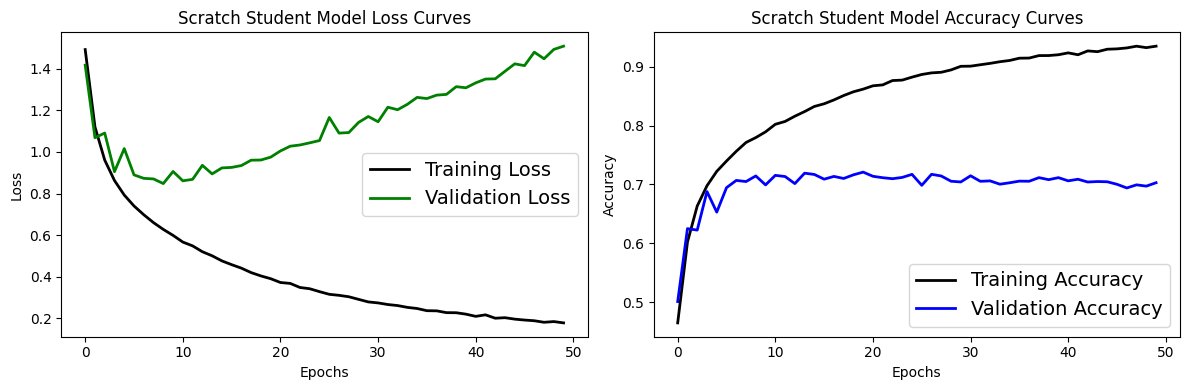

In [ ]:
fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(scratch.history['loss'], 'black', linewidth=2.0)
plt.plot(scratch.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Scratch Student Model Loss Curves', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(scratch.history['sparse_categorical_accuracy'], 'black', linewidth=2.0)
plt.plot(scratch.history['val_sparse_categorical_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Scratch Student Model Accuracy Curves', fontsize=12)

plt.tight_layout()
plt.show()

## Comparing the 3 Models

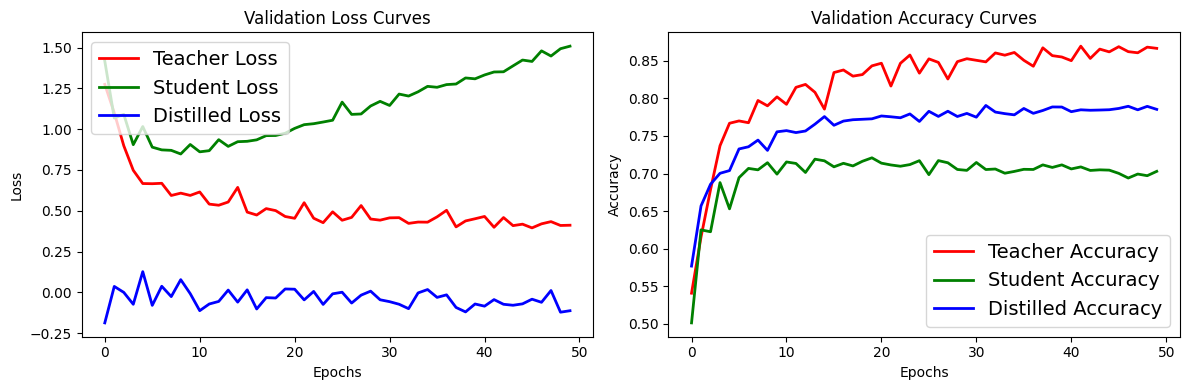

In [ ]:
fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(teachers.history['val_loss'], 'red', linewidth=2.0)
plt.plot(scratch.history['val_loss'], 'green', linewidth=2.0)
plt.plot(dis.history['val_loss'], 'blue', linewidth=2.0)

plt.legend(['Teacher Loss','Student Loss', 'Distilled Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Validation Loss Curves', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(teachers.history['val_sparse_categorical_accuracy'], 'red', linewidth=2.0)
plt.plot(scratch.history['val_sparse_categorical_accuracy'], 'green', linewidth=2.0)
plt.plot(dis.history['val_sparse_categorical_accuracy'], 'blue', linewidth=2.0)

plt.legend(['Teacher Accuracy', 'Student Accuracy', 'Distilled Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Validation Accuracy Curves', fontsize=12)

plt.tight_layout()
plt.show()